# 用Python浅析股票数据

本文将使用Python来可视化股票数据，比如绘制K线图，并且探究各项指标的含义和关系，最后使用移动平均线方法初探投资策略。

## 数据导入

这里将股票数据存储在`stockData.txt`文本文件中，我们使用`pandas.read_table()`函数将文件数据读入成DataFrame格式。其中参数
`usecols=range(15)`限制只读取前15列数据，`parse_dates=[0]`表示将第一列数据解析成时间格式，`index_col=0`则将第一列数据指定为索引。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) #设置绘图尺寸

#读取数据
stock = pd.read_table('stockData.txt', usecols=range(15), parse_dates=[0], index_col=0)
stock = stock[::-1]  #逆序排列
stock.head()

Populating the interactive namespace from numpy and matplotlib


,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
date,,,,,,,,,,,,,,
2015-01-05,11.16,11.39,11.26,10.89,46383.57,0.14,1.26,11.156,11.212,11.198,58648.75,68429.87,97141.81,1.59
2015-01-06,11.13,11.66,11.61,11.03,59199.93,0.35,3.11,11.182,11.155,11.382,54854.38,63401.05,98686.98,2.03
2015-01-07,11.58,11.99,11.92,11.48,86681.38,0.31,2.67,11.366,11.251,11.543,55049.74,61628.07,103010.58,2.97
2015-01-08,11.70,11.92,11.67,11.64,56845.71,-0.25,-2.10,11.516,11.349,11.647,57268.99,61376.00,105823.50,1.95
2015-01-09,11.68,11.71,11.23,11.19,44851.56,-0.44,-3.77,11.538,11.363,11.682,58792.43,60665.93,107924.27,1.54


以上显示了前5行数据，要得到数据的更多信息，可以使用`.info()`方法。它告诉我们该数据一共有20行，索引是时间格式，日期从2015年1月5日到2015年1月30日。总共有14列，并列出了每一列的名称和数据格式，并且没有缺失值。

In [2]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20 entries, 2015-01-05 to 2015-01-30
Data columns (total 14 columns):
    open        20 non-null float64
high            20 non-null float64
close           20 non-null float64
low             20 non-null float64
volume          20 non-null float64
price_change    20 non-null float64
p_change        20 non-null float64
ma5             20 non-null float64
ma10            20 non-null float64
ma20            20 non-null float64
v_ma5           20 non-null float64
v_ma10          20 non-null float64
v_ma20          20 non-null float64
turnover        20 non-null float64
dtypes: float64(14)
memory usage: 2.3 KB


在观察每一列的名称时，我们发现'open'的列名前面似乎与其它列名不太一样，为了更清楚地查看，使用`.columns`得到该数据所有的列名如下：

In [3]:
stock.columns

Index(['    open', 'high', 'close', 'low', 'volume', 'price_change',
       'p_change', 'ma5', 'ma10', 'ma20', 'v_ma5', 'v_ma10', 'v_ma20',
       'turnover'],
      dtype='object')

于是发现'open'列名前存在多余的空格，我们使用如下方法修正列名。

In [4]:
stock.rename(columns={'    open':'open'}, inplace=True)

至此，我们完成了股票数据的导入和清洗工作，接下来将使用可视化的方法来观察这些数据。


## 数据观察

首先，我们观察数据的列名，其含义对应如下：

|open|high|colse|low|volume|price_change|p_change|ma5|ma10|ma20|v_ma5|v_ma10|v_ma20|turnover|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|开盘价|最高价|收盘价|最低价|成交量|价格变动|涨跌幅|5日均价|10日均价|20日均价|5日均量|10日均量|20日均量|换手率|

这些指标总体可分为两类：

* 价格相关指标
    * 当日价格：开盘、收盘价，最高、最低价
    * 价格变化：价格变动和涨跌幅
    * 均价：5、10、20日均价
    
* 成交量相关指标
    * 成交量
    * 换手率：成交量/发行总股数×100%
    * 成交量均量：5、10、20日均量
    
由于这些指标都是随时间变化的，所以让我们先来观察它们的时间序列图。

### 时间序列图

以时间为横坐标，每日的收盘价为纵坐标，做折线图，可以观察股价随时间的波动情况。这里直接使用DataFrame数据格式自带的做图工具，其优点是能够快速做图，并自动优化图形输出形式。

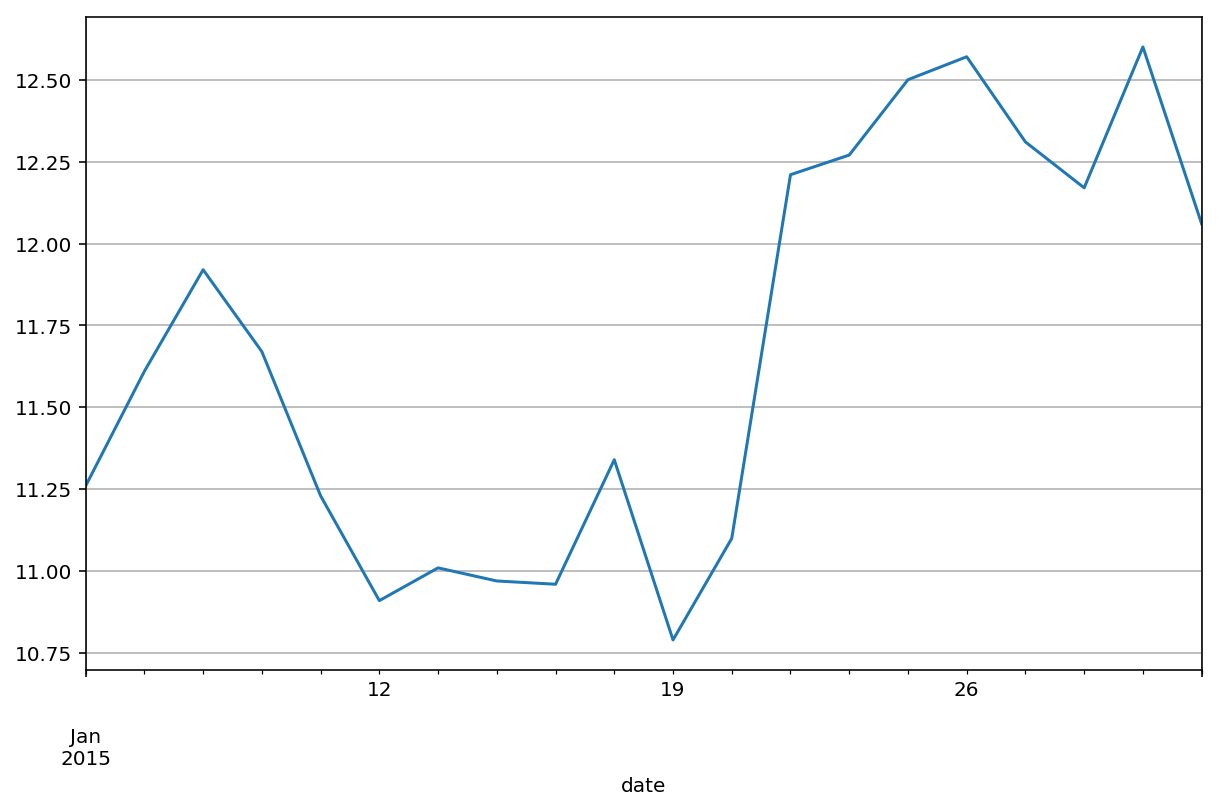

In [5]:
stock['close'].plot(grid=True)

如果我们将每日的开盘、收盘价和最高、最低价以折线的形式绘制在一起，难免显得凌乱，也不便于分析。那么有什么好的方法能够在一张图中显示出这四个指标？答案下面揭晓。

**K线图**

相传K线图起源于日本德川幕府时代，当时的商人用此图来记录米市的行情和价格波动，后来K线图被引入到股票市场。每天的四项指标数据用如下蜡烛形状的图形来记录，不同的颜色代表涨跌情况。

![图片来源：http://wiki.mbalib.com/wiki/K线理论](Kline.jpg)

Matplotlib.finance模块提供了绘制K线图的函数`candlestick_ohlc()`，但如果要绘制比较美观的K线图还是要下点功夫的。下面定义了`pandas_candlestick_ohlc()`函数来绘制适用于本文数据的K线图，其中大部分代码都是在设置坐标轴的格式。

In [6]:
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

def pandas_candlestick_ohlc(stock_data, otherseries=None):    

    # 设置绘图参数，主要是坐标轴 
    mondays = WeekdayLocator(MONDAY) 
    alldays = DayLocator()   
    dayFormatter = DateFormatter('%d')
        
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if stock_data.index[-1] - stock_data.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
    ax.grid(True)
     
    # 创建K线图   
    stock_array = np.array(stock_data.reset_index()[['date','open','high','low','close']])
    stock_array[:,0] = date2num(stock_array[:,0])
    candlestick_ohlc(ax, stock_array, colorup = "red", colordown="green", width=0.4)


    # 可同时绘制其他折线图
    if otherseries is not None:
        for each in otherseries:
            plt.plot(stock_data[each], label=each)            
        plt.legend()
        
        
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.show()
                

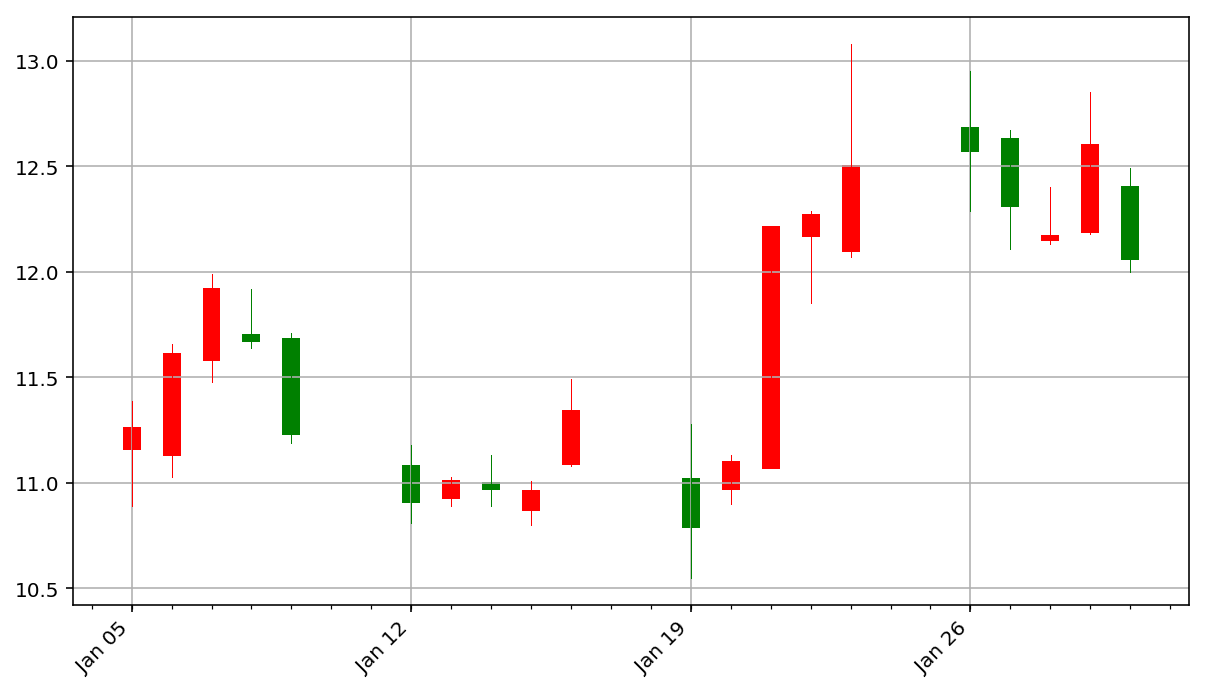

In [7]:
pandas_candlestick_ohlc(stock)

这里红色代表上涨，绿色代表下跌。


**相对变化量**

股票中关注的不是价格的绝对值，而是相对变化量。有多种方式可以衡量股价的相对值，最简单的方法就是将股价除以初始时的价格。

$$ return_{t,0} = \frac{price_t}{price_0} $$

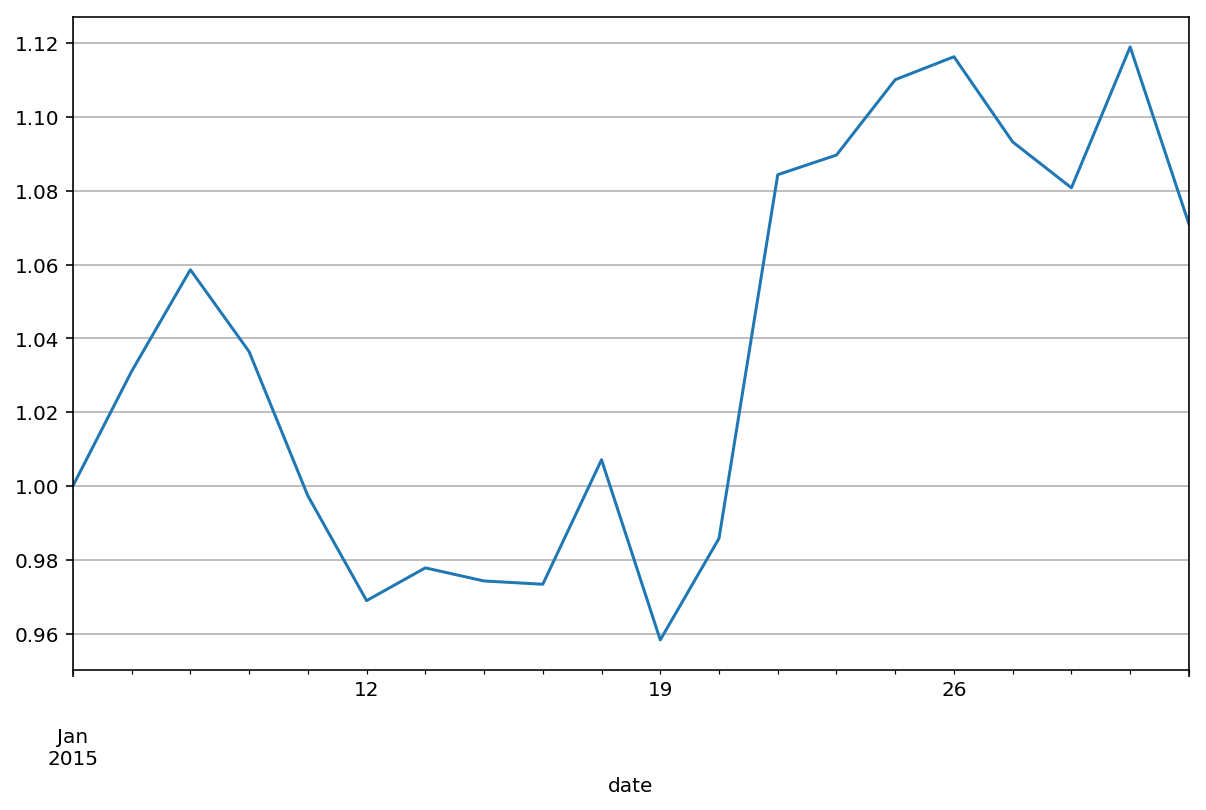

In [8]:
stock['return'] = stock['close'] / stock.close.iloc[0]
stock['return'].plot(grid=True)

第二种方法是计算每天的涨跌幅，但计算方式有两种：

$$ grow_t = \frac{price_{t+1} - price_{t}}{price_t}, 或者 
increase_t = \frac{price_{t} - price_{t-1}}{price_t} $$

这两者可能导致不同的分析结果，样例数据中的涨跌幅使用的是第一个公式，并乘上了100%。

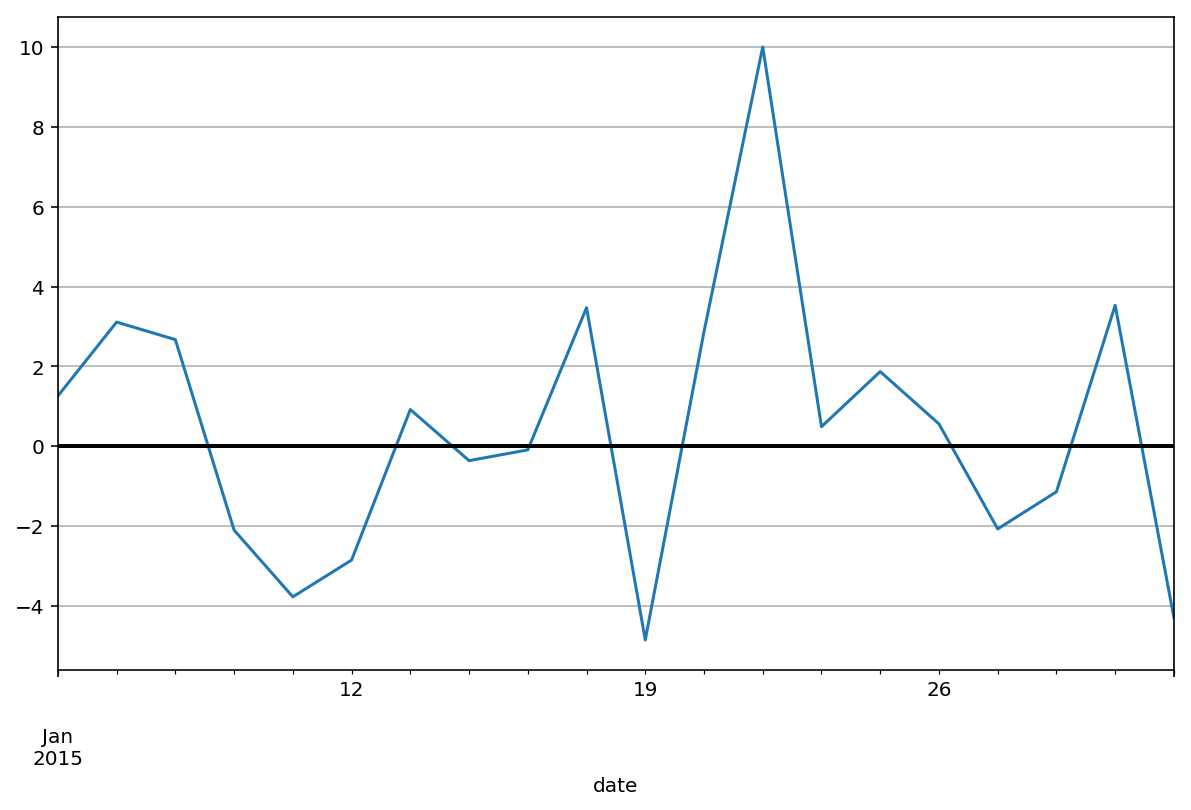

In [9]:
stock['p_change'].plot(grid=True).axhline(y=0, color='black', lw=2)

为了解决第二种方法中的两难选择，我们引入第三种方法，就是计算价格的对数之差，公式如下：

$$ change_t = \log(price_t) - \log(price_{t-1})$$



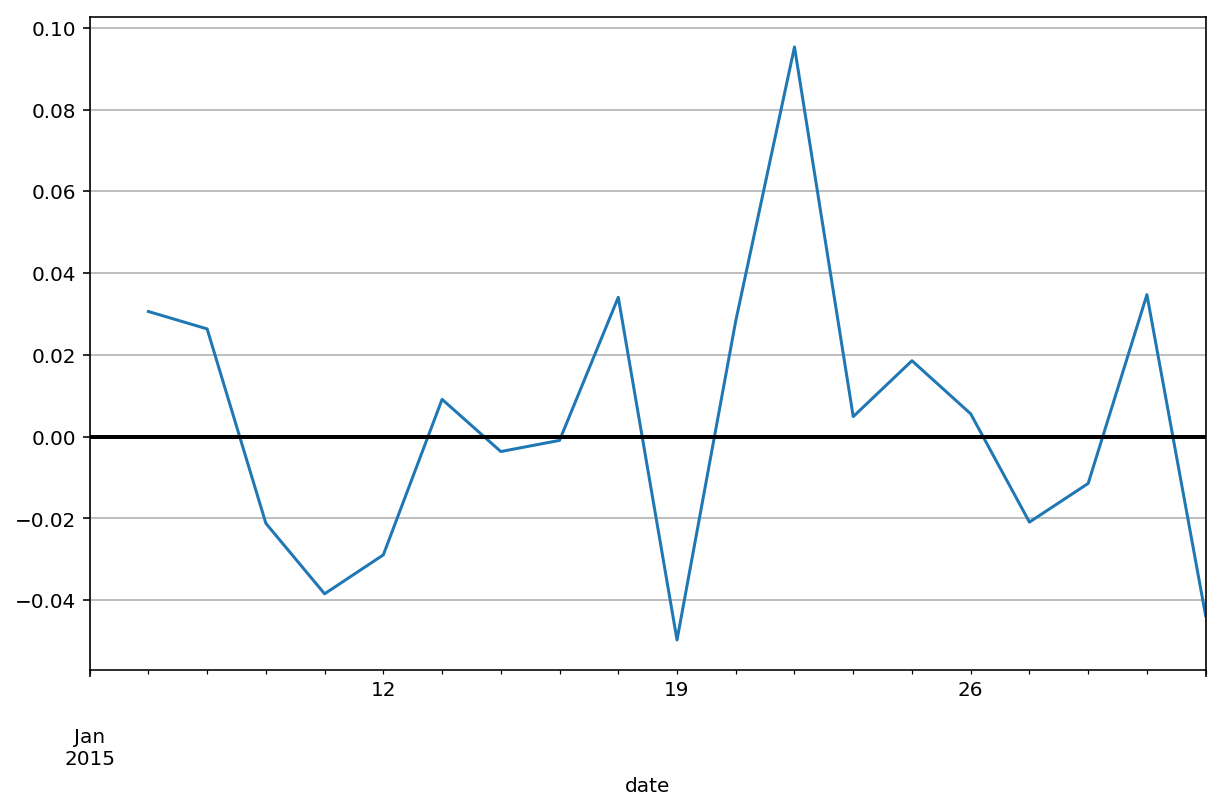

In [10]:
close_price = stock['close']
log_change = np.log(close_price) - np.log(close_price.shift(1))
log_change.plot(grid=True).axhline(y=0, color='black', lw=2)


### 相关关系

在观察了价格的走势之后，我们来看看各指标之间的关系。下面挑选了部分代表性的指标，并使用`pandas.scatter_matrix()`函数，将各项指标数据两两关联做散点图，对角线是每个指标数据的直方图。

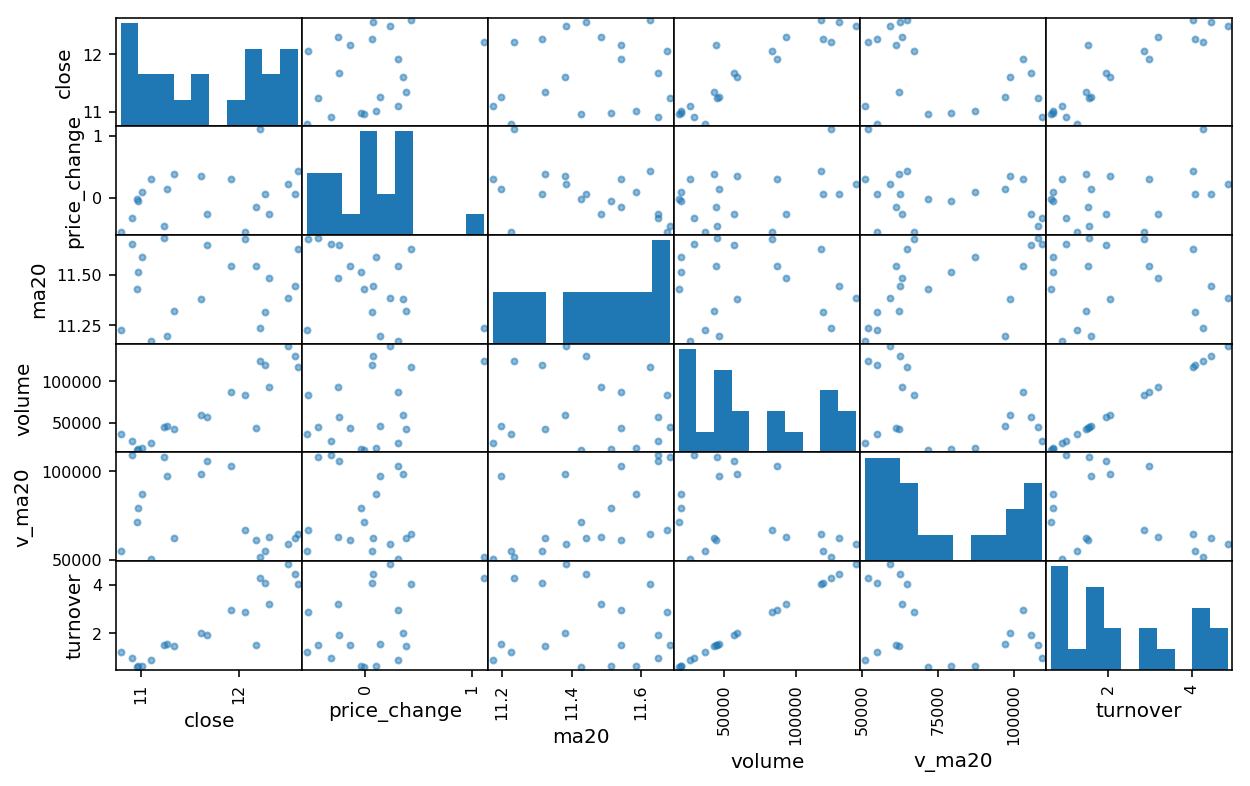

In [11]:
small = stock[['close', 'price_change', 'ma20','volume', 'v_ma20', 'turnover']]
_ = pd.scatter_matrix(small)

图中可以明显发现成交量（volume）和换手率（turnover）有非常明显的线性关系，其实换手率的定义就是：成交量除以发行总股数，再乘以100%。所以下面的分析中我们将换手率指标去除，这里使用了相关性关系来实现数据降维。

上面的散点图看着有些眼花缭乱，我们可以使用`numpy.corrcof()`来直接计算各指标数据间的相关系数。

In [12]:
small = stock[['close', 'price_change', 'ma20','volume', 'v_ma20']]
cov = np.corrcoef(small.T)
cov

array([[ 1.        ,  0.30308764,  0.10785519,  0.91078009, -0.37602193],
       [ 0.30308764,  1.        , -0.45849273,  0.3721832 , -0.25950305],
       [ 0.10785519, -0.45849273,  1.        , -0.06002202,  0.51793654],
       [ 0.91078009,  0.3721832 , -0.06002202,  1.        , -0.37617624],
       [-0.37602193, -0.25950305,  0.51793654, -0.37617624,  1.        ]])

如果觉得看数字还是不够方便，我们继续将上述相关性矩阵转换成图形，如下图所示，其中用颜色来代表相关系数。我们发现位于（0，3）位置的相关系数非常大，查看数值达到0.91。这两个强烈正相关的指标是收盘价和成交量。

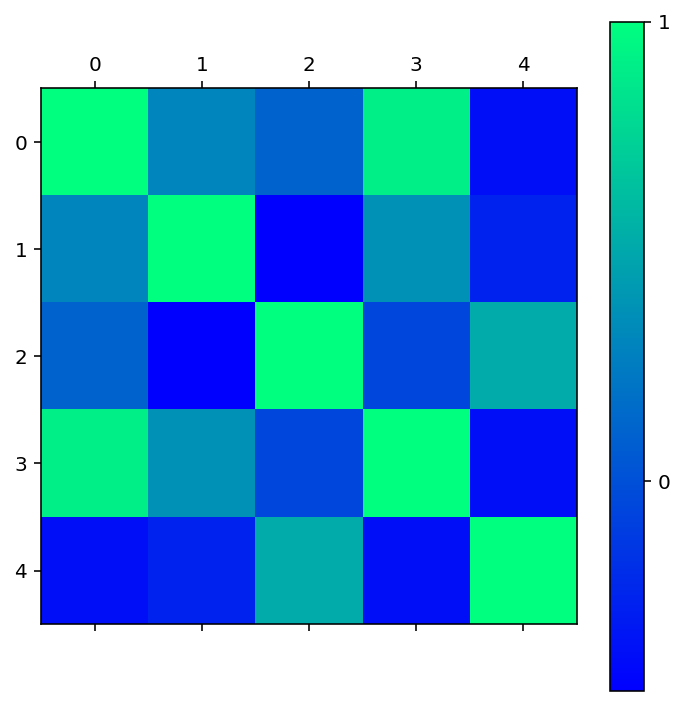

In [13]:
img = plt.matshow(cov,cmap=plt.cm.winter)
plt.colorbar(img, ticks=[-1,0,1])
plt.show()

以上我们用矩阵图表的方式在多个指标中迅速找到了强相关的指标。接着做出收盘价和成交量的折线图，因为它们的数值差异很大，所以我们采用两套纵坐标体系来做图。

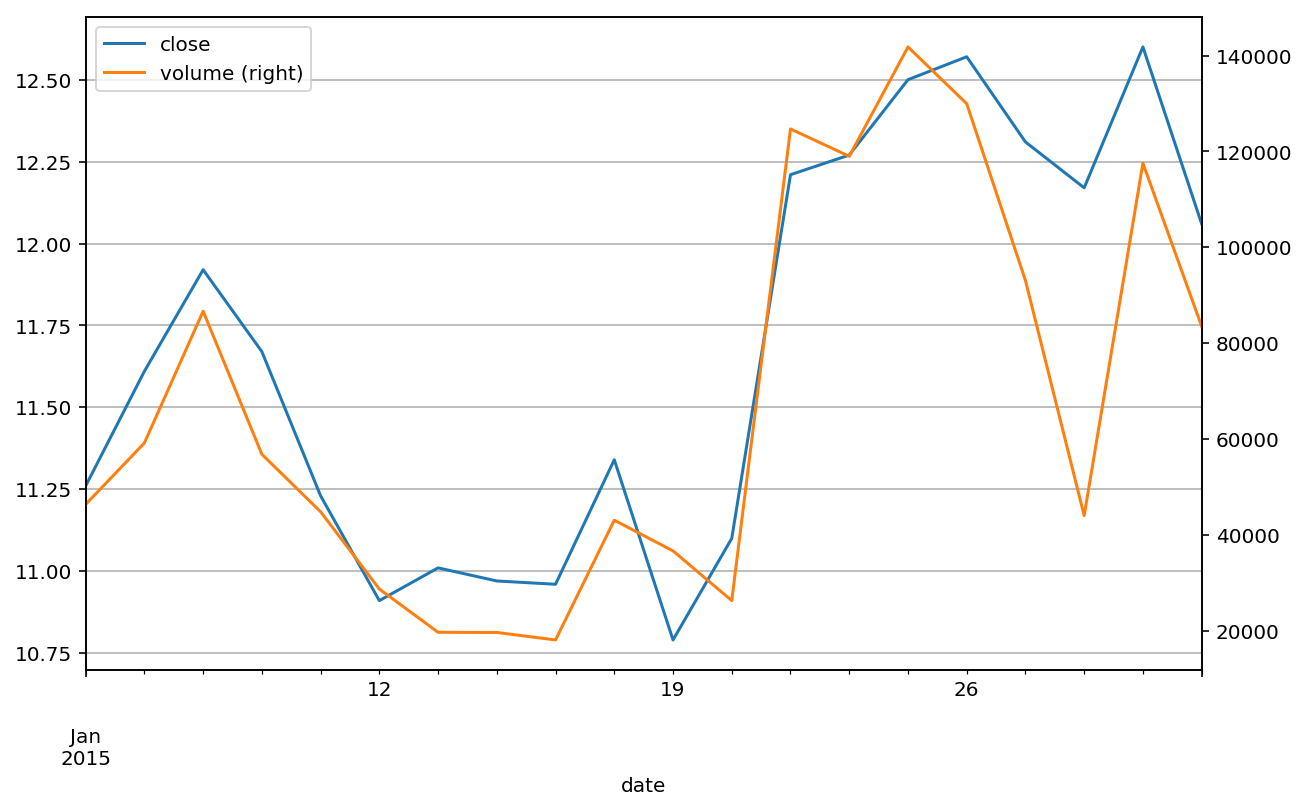

In [14]:
stock[['close','volume']].plot(secondary_y='volume', grid=True)

观察这两个指标的走势，在大部分时候股价上涨，成交量也上涨，反之亦然。但个别情况下则不成立，可能是成交量受到前期的惯性影响，或者还有其他因素。

## 移动平均线

吴军老师曾讲述他的投资经验，大意是说好的投资方式不是做预测，而是能在合适的时机做出合适的应对和决策。同样股市也没法预测，我们能做的是选择恰当的策略应对不同的情况。

好的指标是能驱动决策的。在上面的分析中我们一直没有使用的一类指标是5、10、20日均价，它们又称为移动平均值，下面我们就使用这项指标来演示一个简单的股票交易策略。（*警告：这里仅仅是演示说明，并非投资建议。*）

为了得到更多的数据来演示，我们使用`pandas_datareader`直接从雅虎中下载最近一段时间的谷歌股票数据。

In [15]:
import datetime
import pandas_datareader.data as web

# 设置股票数据的时间跨度
start = datetime.datetime(2016,10,1)
end = datetime.date.today()

# 从yahoo中获取google的股价数据。
goog = web.DataReader("GOOG", "yahoo", start, end)

#修改索引和列的名称，以适应本文的分析
goog.index.rename('date', inplace=True)
goog.rename(columns={'Open':'open', 'High':'high', 'Low':'low', 'Close':'close'}, inplace=True)

goog.head()

,open,high,low,close,Volume,Adj Close
date,,,,,,
2016-10-03,774.250000,776.065002,769.500000,772.559998,1278800,772.559998
2016-10-04,776.030029,778.710022,772.890015,776.429993,1201400,776.429993
2016-10-05,779.309998,782.070007,775.650024,776.469971,1461200,776.469971
2016-10-06,779.000000,780.479980,775.539978,776.859985,1070700,776.859985
2016-10-07,779.659973,779.659973,770.750000,775.080017,933200,775.080017


数据中只有每天的价格和成交量，所以我们需要自己算出5日均价和10日均价，并将均价的折线图（也称移动平均线）与K线图画在一起。

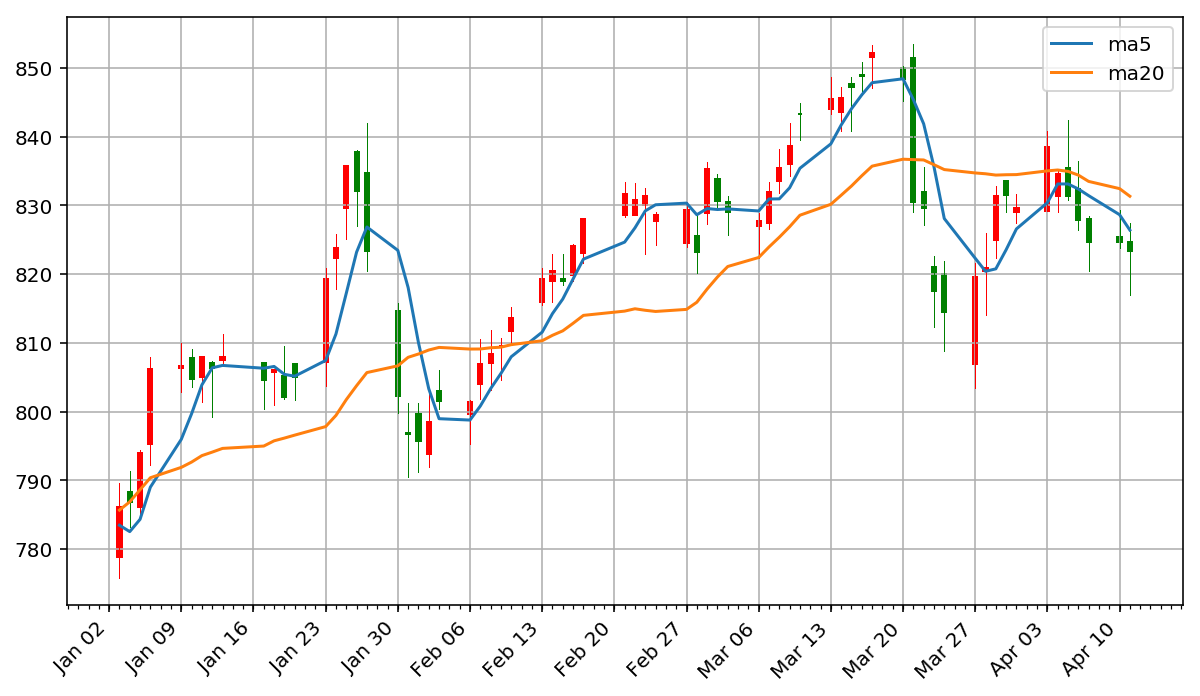

In [16]:
goog["ma5"] = np.round(goog["close"].rolling(window = 5, center = False).mean(), 2)
goog["ma20"] = np.round(goog["close"].rolling(window = 20, center = False).mean(), 2)
goog = goog['2017-01-01':]

pandas_candlestick_ohlc(goog, ['ma5','ma20'])

观察上图，我们发现5日均线与K线图较为接近，而20日均线则更平坦，可见移动平均线具有抹平短期波动的作用，更能反映长期的走势。比较5日均线和20日均线，特别是关注它们的交叉点，这些是交易的时机。移动平均线策略，最简单的方式就是：当5日均线从下方超越20日均线时，买入股票，当5日均线从上方越到20日均线之下时，卖出股票。

为了找出交易的时机，我们计算5日均价和20日均价的差值，并取其正负号，作于下图。当图中水平线出现跳跃的时候就是交易时机。

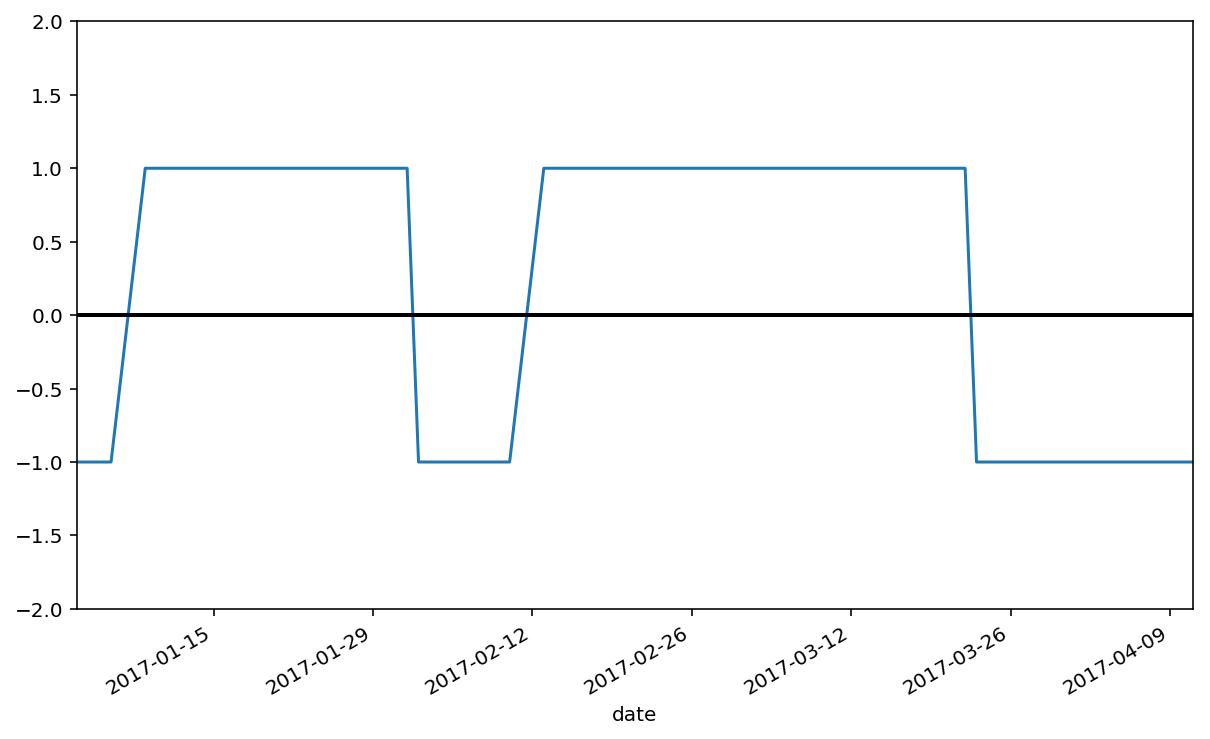

In [17]:
goog['ma5-20'] = goog['ma5'] - goog['ma20']
goog['diff'] = np.sign(goog['ma5-20'])
goog['diff'].plot(ylim=(-2,2)).axhline(y=0, color='black', lw=2)

为了更方便观察，上述计算得到的均价差值，再取其相邻日期的差值，得到信号指标。当信号为1时，表示买入股票；当信号为-1时，表示卖出股票；当信号为0时，不进行任何操作。

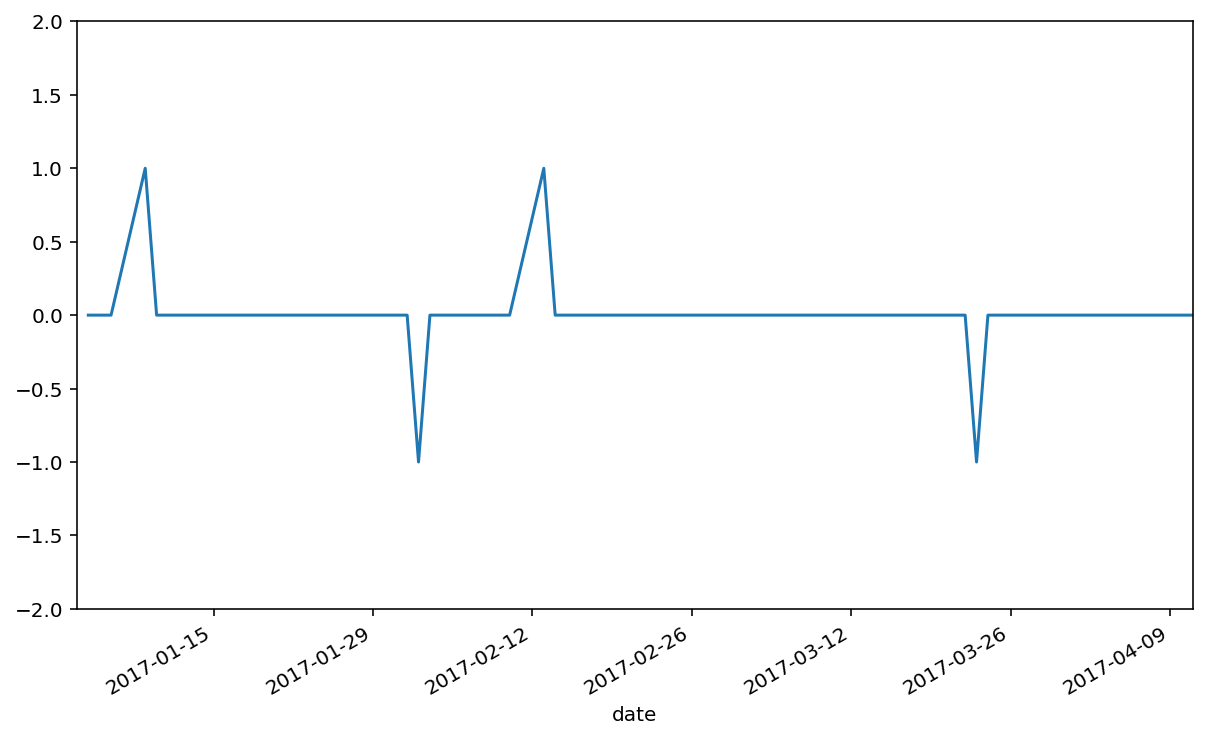

In [18]:
goog['signal'] = np.sign(goog['diff'] - goog['diff'].shift(1))
goog['signal'].plot(ylim=(-2,2))

从上图中看出，从今年初到现在，一共有两轮买进和卖出的时机。到目前为止，似乎一切顺利，那么让我们看下这两轮交易的收益怎么样吧。

In [19]:
trade = pd.concat([
    pd.DataFrame({"price": goog.loc[goog["signal"] == 1, "close"],
                  "operation": "Buy"}),
    pd.DataFrame({"price": goog.loc[goog["signal"] == -1, "close"],
                  "operation": "Sell"})    
])

trade.sort_index(inplace=True)
trade

,operation,price
date,,
2017-01-09,Buy,806.650024
2017-02-02,Sell,798.530029
2017-02-13,Buy,819.239990
2017-03-23,Sell,817.580017


上述表格列出了交易日期、操作和当天的价格。但很遗憾地发现，这两轮交易的卖出价都小于买入价，实际上按上述方法交易我们亏本了！！！

你是否很愤怒呢？原来分析到现在，都是假的呀！我之前就警告过，这里的分析只是演示移动平均线策略的思想，而并非真正的投资建议。股票市场是何其的复杂多变，又如何是一个小小的策略所能战胜的呢？

那么这个策略就一无是处吗？非也！如果考虑更长的时间跨度，比如5年、10年，并考虑更长的均线，比如将20日均线和50日均线比较；虽然过程中也有亏损的时候，但赢的概率更大。也就是说，在更长的时间尺度上该策略也是可行的。但即使你赚了，又能跑赢大盘吗？这时候还需用到其他方法，比如合理配置投资比例等。

还是那句话，股市有风险，投资需谨慎。本文不是分析股票的文章，而是借用股票数据来说明数据分析的基本方法，以及演示什么样的指标是好的指标。

---

参考资料：

* [An Introduction to Stock Market Data Analysis with Python (Part 1)](https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/)

* [An Introduction to Stock Market Data Analysis with Python (Part 2)](https://ntguardian.wordpress.com/2016/09/26/introduction-stock-market-data-python-2/)

* [K线理论](http://wiki.mbalib.com/wiki/K线理论)

* [K线图做图示例](http://matplotlib.org/examples/pylab_examples/finance_demo.html)